In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [1]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

## Autoregressive forecaster

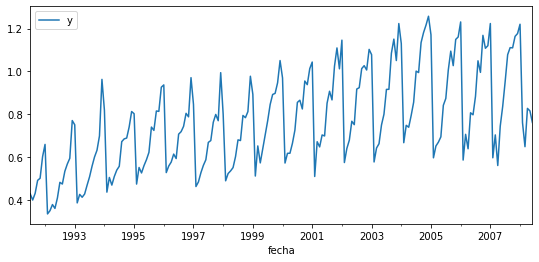

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [6]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False,  
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 0.011051937043503714


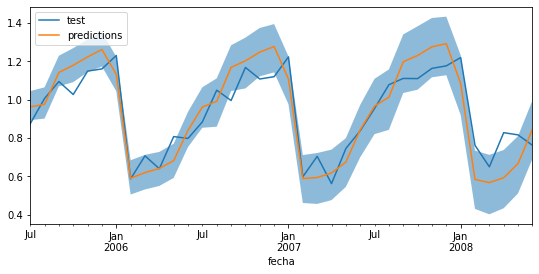

In [12]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000, 
                    in_sample_residuals = True
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [13]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 69.44444444444444


[0.02150972]


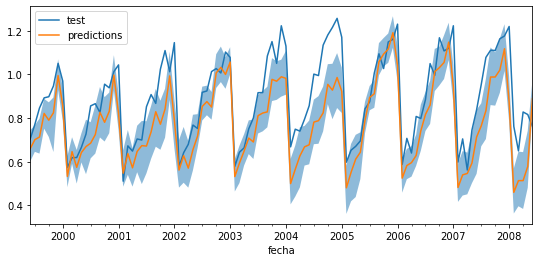

In [10]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [11]:
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict_interval(steps=steps)
print(len(predictions_1[:, 0]), predictions_1[:, 0])
print("")
predictions_2 = forecaster.predict_interval(steps=steps, last_window=datos_test[:steps])
print(len(predictions_2[:, 0]), predictions_2[:, 0])
print("")
predictions_3 = forecaster.predict_interval(steps=steps, last_window=datos_test[steps:steps*2])
print(len(predictions_3[:, 0]), predictions_3[:, 0])
print("")
predictions_4 = forecaster.predict_interval(steps=1, last_window=datos_test[steps*2:steps*3])
print(len(predictions_4[:, 0]), predictions_4[:, 0])
print("")
(predictions.iloc[:, 0] == np.concatenate([predictions_1[:, 0], predictions_2[:, 0], predictions_3[:, 0], predictions_4[:, 0]])).all()

36 [0.65975141 0.70083294 0.71322702 0.82118276 0.79016273 0.82429836
 0.99478547 0.85639271 0.53239718 0.64611528 0.57403328 0.64174981
 0.6692534  0.68494999 0.72421066 0.82635869 0.7805795  0.83090948
 0.99698484 0.82063913 0.54734782 0.63689091 0.57178966 0.64700865
 0.67365281 0.67169315 0.73657855 0.82921632 0.77173991 0.84127572
 0.99326797 0.79089549 0.56161618 0.62756698 0.57048122 0.65508333]

36 [0.7179964  0.85338817 0.8754706  0.85051013 1.00704991 1.03238786
 1.00018232 1.05684515 0.53179721 0.59370291 0.64874451 0.70818416
 0.69024412 0.81112373 0.82304019 0.82852027 0.97751844 0.96902967
 0.98929643 0.98206046 0.49958947 0.56489127 0.62663741 0.66805715
 0.67758601 0.78153956 0.78804939 0.82398326 0.95462158 0.92795873
 0.98601162 0.92275391 0.4802136  0.55092671 0.61167778 0.64344355]

36 [0.78955738 0.89431376 0.91162216 1.05840694 1.09347619 1.11631393
 1.19152211 1.04125414 0.52458912 0.58233782 0.59565852 0.62876208
 0.74089722 0.81648256 0.85960932 1.01275561 1.03

True

In [12]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 47.706422018348626


## Autoreg + 1 exogenous predictor
<br>

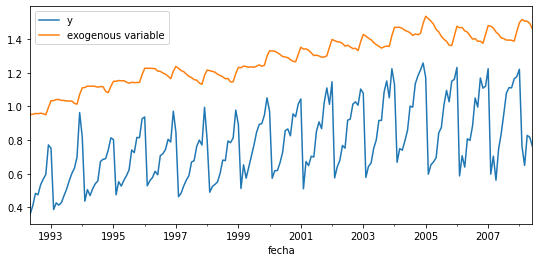

In [14]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

In [16]:
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: LinearRegression() 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True, <class 'pandas.core.series.Series'> 
Exogenous variables names: None 
Training range: [Timestamp('1992-05-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 0.020306077140235624


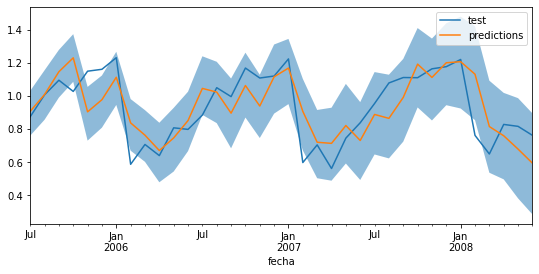

In [15]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [15]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Autoregressive + n exogenous predictors
<br>

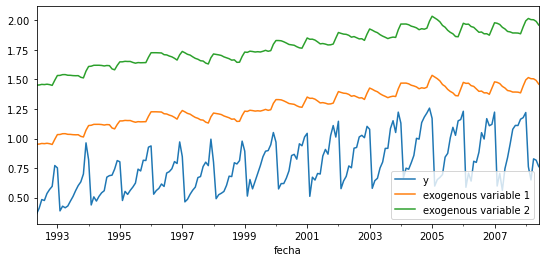

In [16]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.02030607714023512


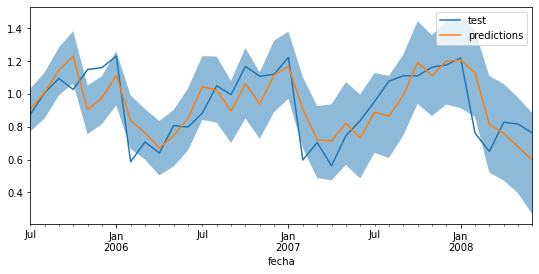

In [17]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [18]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Intervalos estimados con residuos out-of-sample

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


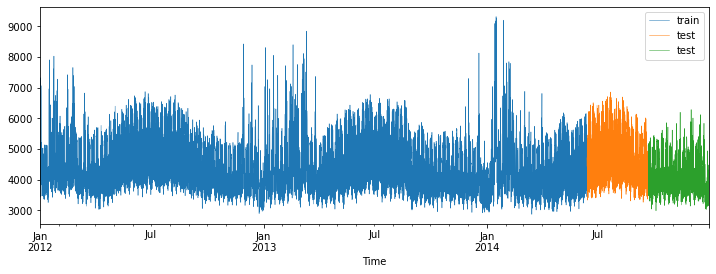

In [19]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
datos = pd.read_csv(url, sep=',')
datos.info()

# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

# Separación datos train-validation-test
# ==============================================================================
dias_test = 100
dias_validacion = 100
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fecha_fin_train   = datos.index[-1] - pd.Timedelta(dias_validacion + dias_test, unit='D')
fecha_inicio_validacion = fecha_fin_train + pd.Timedelta(1, unit='H')
fecha_fin_validacion    = fecha_inicio_validacion + pd.Timedelta(dias_validacion, unit='D')
fecha_inicio_test = fecha_fin_validacion + pd.Timedelta(1, unit='H')

datos_train       = datos.loc[: fecha_fin_train, :]
datos_validacion  = datos.loc[fecha_inicio_validacion:fecha_fin_validacion, :]
datos_test        = datos.loc[fecha_inicio_test:, :]

# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='train', linewidth=0.5)
datos_validacion.Demand.plot(ax=ax, label='test', linewidth=0.5)
datos_test.Demand.plot(ax=ax, label='test', linewidth=0.5)
ax.legend();

In [20]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(normalize=True),
                lags      = 24
             )

forecaster.fit(y=datos_train.Demand)
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Exogenous variable: False
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

In [21]:
# Backtest conjunto validación
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand.loc[:fecha_fin_validacion],
                            initial_train_size = len(datos_train.Demand),
                            steps      = 24,
                            metric     = 'neg_mean_absolute_error'
                        )

Se calculan los errores de validación para utilizarlos como *out-sample-residuals* en la estimación de intervalos de predicción.

In [22]:
forecaster.out_sample_residuals = datos_validacion.Demand - predicciones

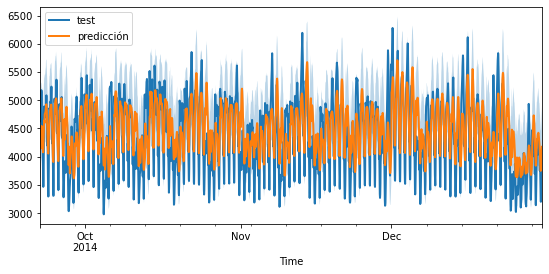

In [23]:
# Backtest con intervalos de predicción para el conjunto de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos_train.Demand) + len(datos_validacion.Demand),
                            steps      = 24,
                            metric     = 'neg_mean_absolute_error',
                            interval            = [5, 95],
                            n_boot              = 1000,
                            in_sample_residuals = False
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.iloc[:, 0].plot(linewidth=2, label='predicción', ax=ax)
ax.fill_between(predicciones.index,
                predicciones.iloc[:, 1],
                predicciones.iloc[:, 2],
                alpha=0.3)
ax.legend();

In [24]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test.Demand >= predicciones.iloc[:, 1]) \
                        & (datos_test.Demand <= predicciones.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 80.03334722801168


El intervalo no consigue la cobertura esperada del 90%

## Información de sesión

In [25]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.3.2
numpy       1.19.5
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.7
sklearn     0.24.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1041-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-30 15:12
